# **CNN + Optuna Tuning - CIFAR10 Dataset**
# Harshini Raju

**NOTE**: Due to lack of GPU and Google Colab's limited resources my training has been constarined to a lower number than expected and/or required.

In [ ]:
%matplotlib inline

from keras.models import Sequential
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, BatchNormalization
from keras.layers import Flatten, MaxPooling2D
from keras.layers import Conv2D
from keras.optimizers import SGD, RMSprop, Adam
from keras.preprocessing import image
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.callbacks import Callback
import sklearn.metrics as metrics


from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input, decode_predictions

from distutils.version import LooseVersion as LV
from keras import __version__

from IPython.display import SVG
import tensorflow as tf
from keras.utils import model_to_dot

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print('Using Keras version:', __version__, 'backend:', K.backend())
assert(LV(__version__) >= LV("2.0.0"))

Using Keras version: 2.13.1 backend: tensorflow


<ipython-input-6-0a278c234ae8>:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  assert(LV(__version__) >= LV("2.0.0"))


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

## **Pre-processing the CIFAR10 Dataset**

Load the data into train and test datasets, shape them appropriately for the mdoel to train and produce optimal solutions

In [ ]:
from keras.datasets import cifar10

In [ ]:
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()

print("Shape of training data:")
print(X_train.shape)
print(Y_train.shape)
print("Shape of test data:")
print(X_test.shape)
print(Y_test.shape)

Shape of training data:
(50000, 32, 32, 3)
(50000, 1)
Shape of test data:
(10000, 32, 32, 3)
(10000, 1)


In [ ]:
y_train = to_categorical(Y_train, num_classes=10)
y_test = to_categorical(Y_test, num_classes=10)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255
X_test /= 255

print("Shape of training data after encoding:")
print(X_train.shape)
print(y_train.shape)
print("Shape of test data:")
print(X_test.shape)
print(y_test.shape)

Shape of training data after encoding:
(50000, 32, 32, 3)
(50000, 10)
Shape of test data:
(10000, 32, 32, 3)
(10000, 10)


In [ ]:
%%time
X = X_train.reshape(50000, 3*32*32)
Xt = X_test.reshape(10000, 3*32*32)
y = y_train.flatten()
yt = y_test.flatten()

# **Implement the model- CNN Model**

In [ ]:
num_classes = 10  # Number of class for the dataset

Implementing a custom Callback function that will help me enable a recursive learnign rate value that follows the formula of

    learning_rate = previous_learning_rate/square_root(n)

where n is the number of the current epoch.

In [ ]:
class LRScheduler(Callback):
    def __init__(self, initial_lr=0.001):
        super(LRScheduler, self).__init__()
        self.initial_lr = initial_lr

    def lr_schedule(self, epoch):
        return self.initial_lr / np.sqrt(epoch + 1)

    def on_epoch_begin(self, epoch, logs=None):
        new_lr = self.lr_schedule(epoch)
        self.model.optimizer.lr = new_lr
        print(f"Epoch {epoch + 1}: Learning rate set to {new_lr:.6f}")

### **CNN with Adam**

In [ ]:
adam_cnn_model = Sequential()

# CONV => RELU => CONV => RELU => POOL => DROPOUT
adam_cnn_model.add(Conv2D(64, (5, 5), padding='same', input_shape=X_train.shape[1:]))
adam_cnn_model.add(Activation('relu'))
adam_cnn_model.add(MaxPooling2D(pool_size=(3, 3)))
adam_cnn_model.add(Dropout(0.25))

# CONV => RELU => CONV => RELU => POOL => DROPOUT
adam_cnn_model.add(Conv2D(128, (5, 5), padding='same'))
adam_cnn_model.add(Activation('relu'))
adam_cnn_model.add(MaxPooling2D(pool_size=(3, 3)))
adam_cnn_model.add(Dropout(0.5))

# FLATTERN => DENSE => RELU => DROPOUT
adam_cnn_model.add(Flatten())
adam_cnn_model.add(Dense(1000))
adam_cnn_model.add(Activation('relu'))
adam_cnn_model.add(Dropout(0.5))
# a softmax classifier
adam_cnn_model.add(Dense(num_classes))
adam_cnn_model.add(Activation('softmax'))

# initiate Adam optimizer
optimizer = Adam(learning_rate=0.001)

adam_cnn_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
adam_cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        4864      
                                                                 
 activation (Activation)     (None, 32, 32, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 10, 10, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 10, 10, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 128)       204928    
                                                                 
 activation_1 (Activation)   (None, 10, 10, 128)       0         
                                                        

In [ ]:
%%time
epochs = 30
lr_scheduler = LRScheduler(initial_lr=0.001)
cnn_history = adam_cnn_model.fit(X_train, y_train, epochs=epochs, batch_size=128,
                    verbose=2, validation_split=0.3, callbacks= [lr_scheduler])

Epoch 1: Learning rate set to 0.001000
Epoch 1/30
274/274 - 14s - loss: 1.7600 - accuracy: 0.3549 - val_loss: 1.4090 - val_accuracy: 0.4885 - 14s/epoch - 53ms/step
Epoch 2: Learning rate set to 0.000707
Epoch 2/30
274/274 - 3s - loss: 1.3979 - accuracy: 0.4931 - val_loss: 1.2397 - val_accuracy: 0.5672 - 3s/epoch - 10ms/step
Epoch 3: Learning rate set to 0.000577
Epoch 3/30
274/274 - 3s - loss: 1.2738 - accuracy: 0.5441 - val_loss: 1.1454 - val_accuracy: 0.5979 - 3s/epoch - 9ms/step
Epoch 4: Learning rate set to 0.000500
Epoch 4/30
274/274 - 3s - loss: 1.1907 - accuracy: 0.5771 - val_loss: 1.0855 - val_accuracy: 0.6291 - 3s/epoch - 10ms/step
Epoch 5: Learning rate set to 0.000447
Epoch 5/30
274/274 - 3s - loss: 1.1234 - accuracy: 0.6023 - val_loss: 1.0060 - val_accuracy: 0.6540 - 3s/epoch - 10ms/step
Epoch 6: Learning rate set to 0.000408
Epoch 6/30
274/274 - 3s - loss: 1.0690 - accuracy: 0.6200 - val_loss: 0.9927 - val_accuracy: 0.6559 - 3s/epoch - 10ms/step
Epoch 7: Learning rate set 

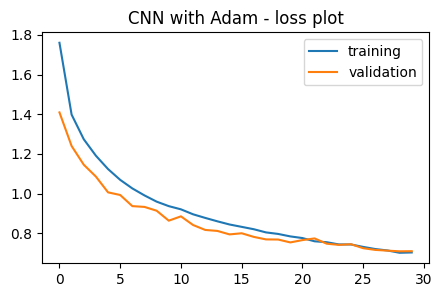

In [ ]:
plt.figure(figsize=(5,3))
plt.plot(cnn_history.epoch,cnn_history.history['loss'], label='training')
plt.plot(cnn_history.epoch,cnn_history.history['val_loss'], label='validation')
plt.title('CNN with Adam - loss plot')
plt.legend(loc='best')

### **CNN with SGD**

In [ ]:
sgd_cnn_model = Sequential()
# CONV => RELU => CONV => RELU => POOL => DROPOUT
sgd_cnn_model.add(Conv2D(128, (5, 5), padding='same',input_shape=X_train.shape[1:]))
sgd_cnn_model.add(Activation('relu'))
sgd_cnn_model.add(Conv2D(128, (5, 5)))
sgd_cnn_model.add(Activation('relu'))
sgd_cnn_model.add(MaxPooling2D(pool_size=(3, 3)))
sgd_cnn_model.add(Dropout(0.25))

# CONV => RELU => CONV => RELU => POOL => DROPOUT
sgd_cnn_model.add(Conv2D(256, (5, 5), padding='same'))
sgd_cnn_model.add(Activation('relu'))
sgd_cnn_model.add(Conv2D(256, (5, 5)))
sgd_cnn_model.add(Activation('relu'))
sgd_cnn_model.add(MaxPooling2D(pool_size=(3, 3)))
sgd_cnn_model.add(Dropout(0.25))

# FLATTERN => DENSE => RELU => DROPOUT
sgd_cnn_model.add(Flatten())
sgd_cnn_model.add(Dense(1024))
sgd_cnn_model.add(Activation('relu'))
sgd_cnn_model.add(Dropout(0.5))
# a softmax classifier
sgd_cnn_model.add(Dense(num_classes))
sgd_cnn_model.add(Activation('softmax'))

# initiate Adam optimizer
optimizer = SGD(learning_rate=0.001)

sgd_cnn_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

sgd_cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 32, 32, 128)       9728      
                                                                 
 activation_4 (Activation)   (None, 32, 32, 128)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 128)       409728    
                                                                 
 activation_5 (Activation)   (None, 28, 28, 128)       0         
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 9, 9, 128)         0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 9, 9, 128)         0         
                                                      

In [ ]:
%%time
epochs = 30
lr_scheduler = LRScheduler(initial_lr=0.001)
cnn_history_sgd = sgd_cnn_model.fit(X_train, y_train, epochs=epochs, batch_size=128,
                    verbose=2, validation_split=0.3, callbacks= [lr_scheduler])

Epoch 1: Learning rate set to 0.001000
Epoch 1/30
274/274 - 19s - loss: 2.3033 - accuracy: 0.1011 - val_loss: 2.3013 - val_accuracy: 0.1265 - 19s/epoch - 69ms/step
Epoch 2: Learning rate set to 0.000707
Epoch 2/30
274/274 - 14s - loss: 2.3019 - accuracy: 0.1044 - val_loss: 2.3004 - val_accuracy: 0.1147 - 14s/epoch - 52ms/step
Epoch 3: Learning rate set to 0.000577
Epoch 3/30
274/274 - 14s - loss: 2.3014 - accuracy: 0.1061 - val_loss: 2.2997 - val_accuracy: 0.1127 - 14s/epoch - 53ms/step
Epoch 4: Learning rate set to 0.000500
Epoch 4/30
274/274 - 14s - loss: 2.3008 - accuracy: 0.1063 - val_loss: 2.2991 - val_accuracy: 0.1124 - 14s/epoch - 52ms/step
Epoch 5: Learning rate set to 0.000447
Epoch 5/30
274/274 - 13s - loss: 2.3000 - accuracy: 0.1137 - val_loss: 2.2986 - val_accuracy: 0.1115 - 13s/epoch - 47ms/step
Epoch 6: Learning rate set to 0.000408
Epoch 6/30
274/274 - 13s - loss: 2.2995 - accuracy: 0.1147 - val_loss: 2.2981 - val_accuracy: 0.1119 - 13s/epoch - 47ms/step
Epoch 7: Learnin

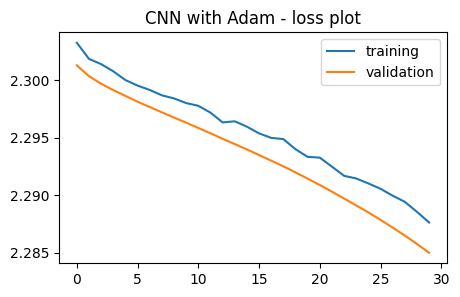

In [ ]:
plt.figure(figsize=(5,3))
plt.plot(cnn_history_sgd.epoch,cnn_history_sgd.history['loss'], label='training')
plt.plot(cnn_history_sgd.epoch,cnn_history_sgd.history['val_loss'], label='validation')
plt.title('CNN with Adam - loss plot')
plt.legend(loc='best')

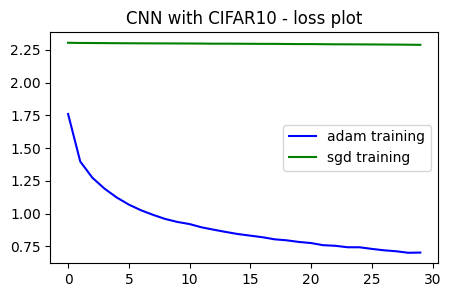

In [ ]:
plt.figure(figsize=(5,3))
plt.plot(cnn_history.epoch,cnn_history.history['loss'], 'b', label='adam training',)
plt.plot(cnn_history_sgd.epoch,cnn_history_sgd.history['loss'], 'g', label='sgd training')
plt.title('CNN with CIFAR10 - loss plot')
plt.legend(loc='best')

**Inference:**


*   Adam performance is significantly better than the SGD performance in terms of lower loss values
* The SGD optimizer has not affected the loss value reduction whereas Adam optimizer has minimized the loss value as expected
*  The Adam optimizer brings down the loss value drastically between the first 10 epochs and hence the curve is deeper.
* Adam redcues the loss value incrementally in smaller installments hence the curve depth is much less and almsot falt in comparison to that of SGD optimizer


# **SGD and Adam Optimizers - Optuna**

In [ ]:
!pip install --quiet optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.2/404.2 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 9.1 MB/s eta 0:00:00


In [ ]:
import optuna
from packaging import version

In [ ]:
from optuna import Trial

def objective(trial: Trial):

    # Defining the hyperparameters to be optimized
    learning_rate = trial.suggest_float('learning_rate', 1e-6, 1e-1, log=True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.6)

    # Form the layers of the model
    cnn_model = Sequential()

    # CONV => RELU => CONV => RELU => POOL => DROPOUT
    cnn_model.add(Conv2D(64, (5, 5), padding='same', input_shape=X_train.shape[1:]))
    cnn_model.add(Activation('relu'))
    cnn_model.add(MaxPooling2D(pool_size=(3, 3)))
    cnn_model.add(Dropout(0.25))

    # CONV => RELU => CONV => RELU => POOL => DROPOUT
    cnn_model.add(Conv2D(128, (5, 5), padding='same'))
    cnn_model.add(Activation('relu'))
    cnn_model.add(MaxPooling2D(pool_size=(3, 3)))
    cnn_model.add(Dropout(0.5))

    # FLATTERN => DENSE => RELU => DROPOUT
    cnn_model.add(Flatten())
    cnn_model.add(Dense(1000))
    cnn_model.add(Activation('relu'))
    cnn_model.add(Dropout(0.5))
    # a softmax classifier
    cnn_model.add(Dense(num_classes))
    cnn_model.add(Activation('softmax'))

    #choosing optimiser for current trail acording to the suggest functionality
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD"])
    print(f'Optimzer: {optimizer_name}')
    if optimizer_name == "Adam":
      optimizer = Adam(learning_rate=learning_rate)
    else:
      optimizer = SGD(learning_rate = learning_rate)

    # Compile the model with the chosen optimiser and categorical_crossentropy
    #         loss function as it is a model to predict the categories
    cnn_model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

    # Define the custom learning rate scheduler
    class CustomLRScheduler(tf.keras.callbacks.Callback):
        def on_epoch_begin(self, epoch, logs=None):

            new_lr = 1 / np.sqrt(epoch+1)
            K.set_value(self.model.optimizer.lr, new_lr)
            print(f'Epoch {epoch + 1}: Learning Rate = {new_lr}')

    lr_scheduler = CustomLRScheduler()

    # Train the model
    history = cnn_model.fit(X_train, y_train,
        epochs=45,
        batch_size=128,
        validation_data=(X_test, y_test),
        validation_batch_size=128,
        callbacks=[lr_scheduler],
        verbose=0
    )

    # Return the value to be minimized
    return history.history['val_loss'][-1]

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=5)

# Get the best hyperparameters
best_params = study.best_params
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-10-08 00:31:17,181] A new study created in memory with name: no-name-583de852-6d54-4e8b-9121-6f31e8086f83


Optimzer: SGD
Epoch 1: Learning Rate = 1.0
Epoch 2: Learning Rate = 0.7071067811865475
Epoch 3: Learning Rate = 0.5773502691896258
Epoch 4: Learning Rate = 0.5
Epoch 5: Learning Rate = 0.4472135954999579
Epoch 6: Learning Rate = 0.4082482904638631
Epoch 7: Learning Rate = 0.3779644730092272
Epoch 8: Learning Rate = 0.35355339059327373
Epoch 9: Learning Rate = 0.3333333333333333
Epoch 10: Learning Rate = 0.31622776601683794
Epoch 11: Learning Rate = 0.30151134457776363
Epoch 12: Learning Rate = 0.2886751345948129
Epoch 13: Learning Rate = 0.2773500981126146
Epoch 14: Learning Rate = 0.2672612419124244
Epoch 15: Learning Rate = 0.2581988897471611
Epoch 16: Learning Rate = 0.25
Epoch 17: Learning Rate = 0.24253562503633297
Epoch 18: Learning Rate = 0.23570226039551587
Epoch 19: Learning Rate = 0.22941573387056174
Epoch 20: Learning Rate = 0.22360679774997896
Epoch 21: Learning Rate = 0.2182178902359924
Epoch 22: Learning Rate = 0.21320071635561041
Epoch 23: Learning Rate = 0.2085144140570

[I 2023-10-08 00:33:59,540] Trial 0 finished with value: 1.006553292274475 and parameters: {'learning_rate': 0.00018245273360899624, 'dropout_rate': 0.21209783638739008, 'optimizer': 'SGD'}. Best is trial 0 with value: 1.006553292274475.


Optimzer: Adam
Epoch 1: Learning Rate = 1.0
Epoch 2: Learning Rate = 0.7071067811865475
Epoch 3: Learning Rate = 0.5773502691896258
Epoch 4: Learning Rate = 0.5
Epoch 5: Learning Rate = 0.4472135954999579
Epoch 6: Learning Rate = 0.4082482904638631
Epoch 7: Learning Rate = 0.3779644730092272
Epoch 8: Learning Rate = 0.35355339059327373
Epoch 9: Learning Rate = 0.3333333333333333
Epoch 10: Learning Rate = 0.31622776601683794
Epoch 11: Learning Rate = 0.30151134457776363
Epoch 12: Learning Rate = 0.2886751345948129
Epoch 13: Learning Rate = 0.2773500981126146
Epoch 14: Learning Rate = 0.2672612419124244
Epoch 15: Learning Rate = 0.2581988897471611
Epoch 16: Learning Rate = 0.25
Epoch 17: Learning Rate = 0.24253562503633297
Epoch 18: Learning Rate = 0.23570226039551587
Epoch 19: Learning Rate = 0.22941573387056174
Epoch 20: Learning Rate = 0.22360679774997896
Epoch 21: Learning Rate = 0.2182178902359924
Epoch 22: Learning Rate = 0.21320071635561041
Epoch 23: Learning Rate = 0.208514414057

[I 2023-10-08 00:37:24,287] Trial 1 finished with value: 2.3195459842681885 and parameters: {'learning_rate': 0.038313988469097386, 'dropout_rate': 0.26675755870381157, 'optimizer': 'Adam'}. Best is trial 0 with value: 1.006553292274475.


Optimzer: Adam
Epoch 1: Learning Rate = 1.0
Epoch 2: Learning Rate = 0.7071067811865475
Epoch 3: Learning Rate = 0.5773502691896258
Epoch 4: Learning Rate = 0.5
Epoch 5: Learning Rate = 0.4472135954999579
Epoch 6: Learning Rate = 0.4082482904638631
Epoch 7: Learning Rate = 0.3779644730092272
Epoch 8: Learning Rate = 0.35355339059327373
Epoch 9: Learning Rate = 0.3333333333333333
Epoch 10: Learning Rate = 0.31622776601683794
Epoch 11: Learning Rate = 0.30151134457776363
Epoch 12: Learning Rate = 0.2886751345948129
Epoch 13: Learning Rate = 0.2773500981126146
Epoch 14: Learning Rate = 0.2672612419124244
Epoch 15: Learning Rate = 0.2581988897471611
Epoch 16: Learning Rate = 0.25
Epoch 17: Learning Rate = 0.24253562503633297
Epoch 18: Learning Rate = 0.23570226039551587
Epoch 19: Learning Rate = 0.22941573387056174
Epoch 20: Learning Rate = 0.22360679774997896
Epoch 21: Learning Rate = 0.2182178902359924
Epoch 22: Learning Rate = 0.21320071635561041
Epoch 23: Learning Rate = 0.208514414057

[I 2023-10-08 00:40:02,830] Trial 2 finished with value: 2.3170838356018066 and parameters: {'learning_rate': 0.045290712535573374, 'dropout_rate': 0.2633446192723361, 'optimizer': 'Adam'}. Best is trial 0 with value: 1.006553292274475.


Optimzer: Adam
Epoch 1: Learning Rate = 1.0
Epoch 2: Learning Rate = 0.7071067811865475
Epoch 3: Learning Rate = 0.5773502691896258
Epoch 4: Learning Rate = 0.5
Epoch 5: Learning Rate = 0.4472135954999579
Epoch 6: Learning Rate = 0.4082482904638631
Epoch 7: Learning Rate = 0.3779644730092272
Epoch 8: Learning Rate = 0.35355339059327373
Epoch 9: Learning Rate = 0.3333333333333333
Epoch 10: Learning Rate = 0.31622776601683794
Epoch 11: Learning Rate = 0.30151134457776363
Epoch 12: Learning Rate = 0.2886751345948129
Epoch 13: Learning Rate = 0.2773500981126146
Epoch 14: Learning Rate = 0.2672612419124244
Epoch 15: Learning Rate = 0.2581988897471611
Epoch 16: Learning Rate = 0.25
Epoch 17: Learning Rate = 0.24253562503633297
Epoch 18: Learning Rate = 0.23570226039551587
Epoch 19: Learning Rate = 0.22941573387056174
Epoch 20: Learning Rate = 0.22360679774997896
Epoch 21: Learning Rate = 0.2182178902359924
Epoch 22: Learning Rate = 0.21320071635561041
Epoch 23: Learning Rate = 0.208514414057

[I 2023-10-08 00:43:27,106] Trial 3 finished with value: 45.106807708740234 and parameters: {'learning_rate': 0.0002528205105659354, 'dropout_rate': 0.11940762572374561, 'optimizer': 'Adam'}. Best is trial 0 with value: 1.006553292274475.


Optimzer: SGD
Epoch 1: Learning Rate = 1.0
Epoch 2: Learning Rate = 0.7071067811865475
Epoch 3: Learning Rate = 0.5773502691896258
Epoch 4: Learning Rate = 0.5
Epoch 5: Learning Rate = 0.4472135954999579
Epoch 6: Learning Rate = 0.4082482904638631
Epoch 7: Learning Rate = 0.3779644730092272
Epoch 8: Learning Rate = 0.35355339059327373
Epoch 9: Learning Rate = 0.3333333333333333
Epoch 10: Learning Rate = 0.31622776601683794
Epoch 11: Learning Rate = 0.30151134457776363
Epoch 12: Learning Rate = 0.2886751345948129
Epoch 13: Learning Rate = 0.2773500981126146
Epoch 14: Learning Rate = 0.2672612419124244
Epoch 15: Learning Rate = 0.2581988897471611
Epoch 16: Learning Rate = 0.25
Epoch 17: Learning Rate = 0.24253562503633297
Epoch 18: Learning Rate = 0.23570226039551587
Epoch 19: Learning Rate = 0.22941573387056174
Epoch 20: Learning Rate = 0.22360679774997896
Epoch 21: Learning Rate = 0.2182178902359924
Epoch 22: Learning Rate = 0.21320071635561041
Epoch 23: Learning Rate = 0.2085144140570

[I 2023-10-08 00:46:05,120] Trial 4 finished with value: 2.3026957511901855 and parameters: {'learning_rate': 1.0977234423641313e-05, 'dropout_rate': 0.5490505461259022, 'optimizer': 'SGD'}. Best is trial 0 with value: 1.006553292274475.


  Value:  1.006553292274475
  Params: 
    learning_rate: 0.00018245273360899624
    dropout_rate: 0.21209783638739008
    optimizer: SGD


In [ ]:
fig = optuna.visualization.plot_optimization_history(study)
fig.show()

**NOTE: As the optuna plots are not visible when adding the Colab notebook to the repo I have added them as images for your simple reference**

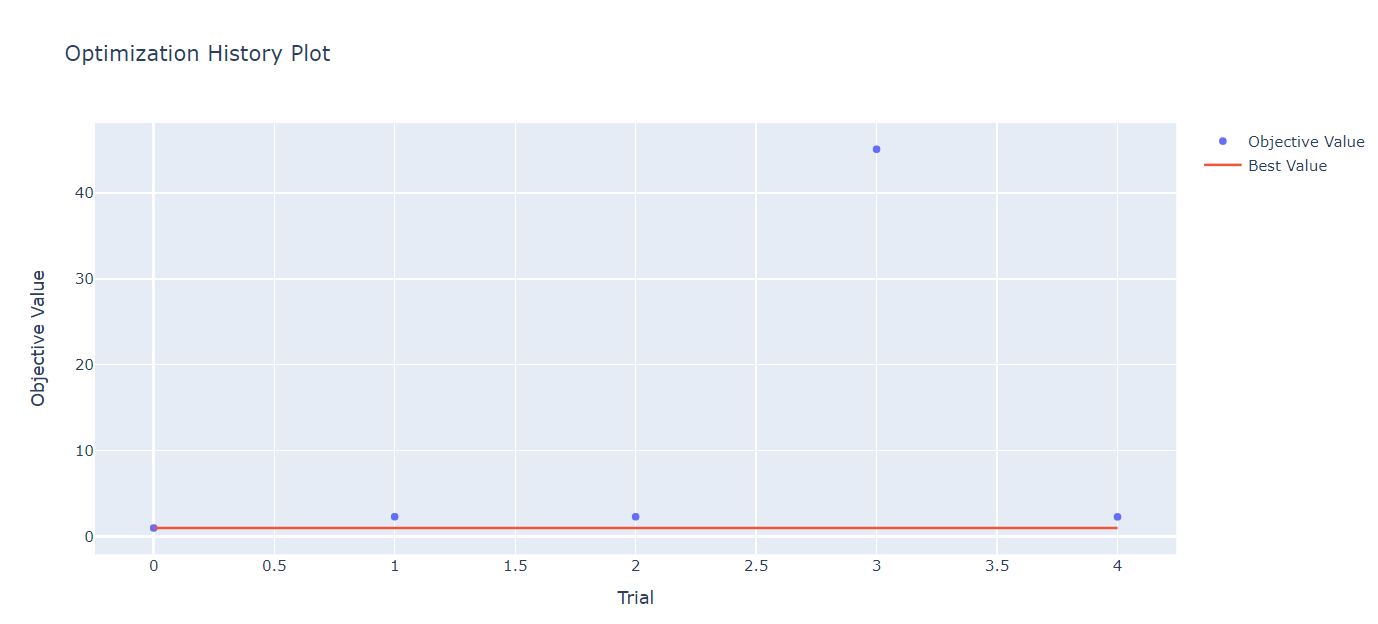

In [ ]:
fig = optuna.visualization.plot_contour(study, params=["learning_rate", "dropout_rate"])
fig.show()

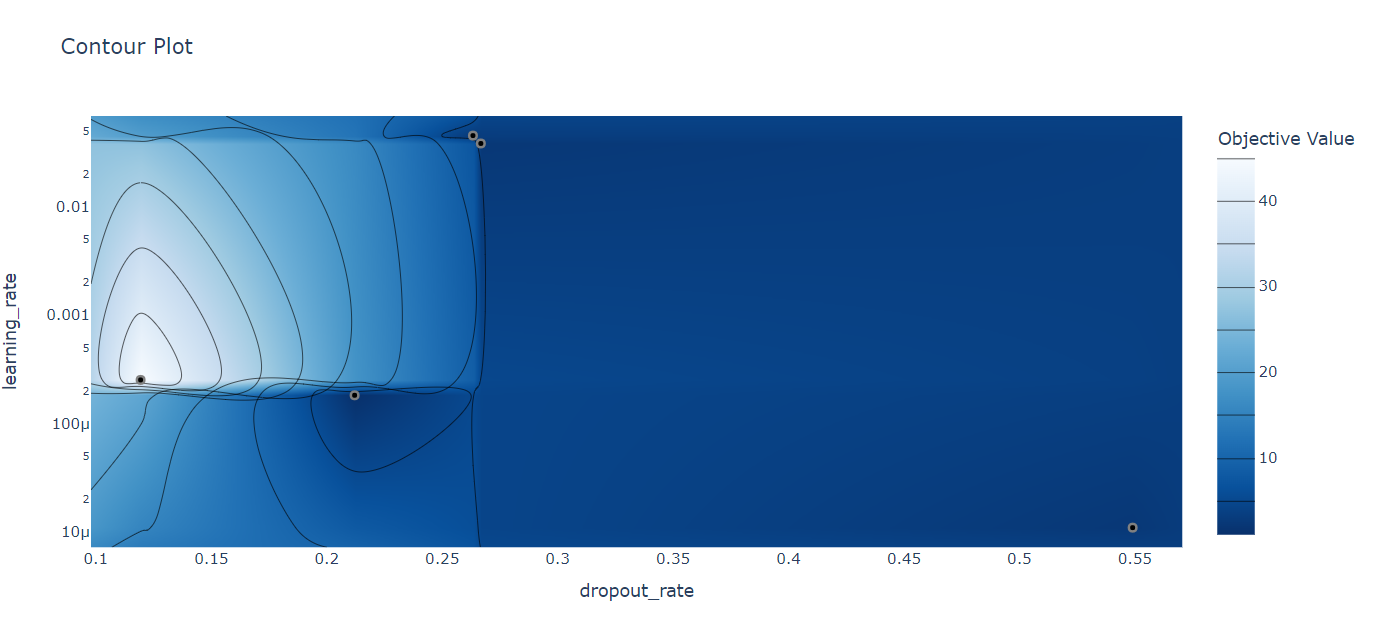

In [ ]:
fig = optuna.visualization.plot_contour(study, params=["learning_rate", "dropout_rate", "optimizer"])
fig.show()

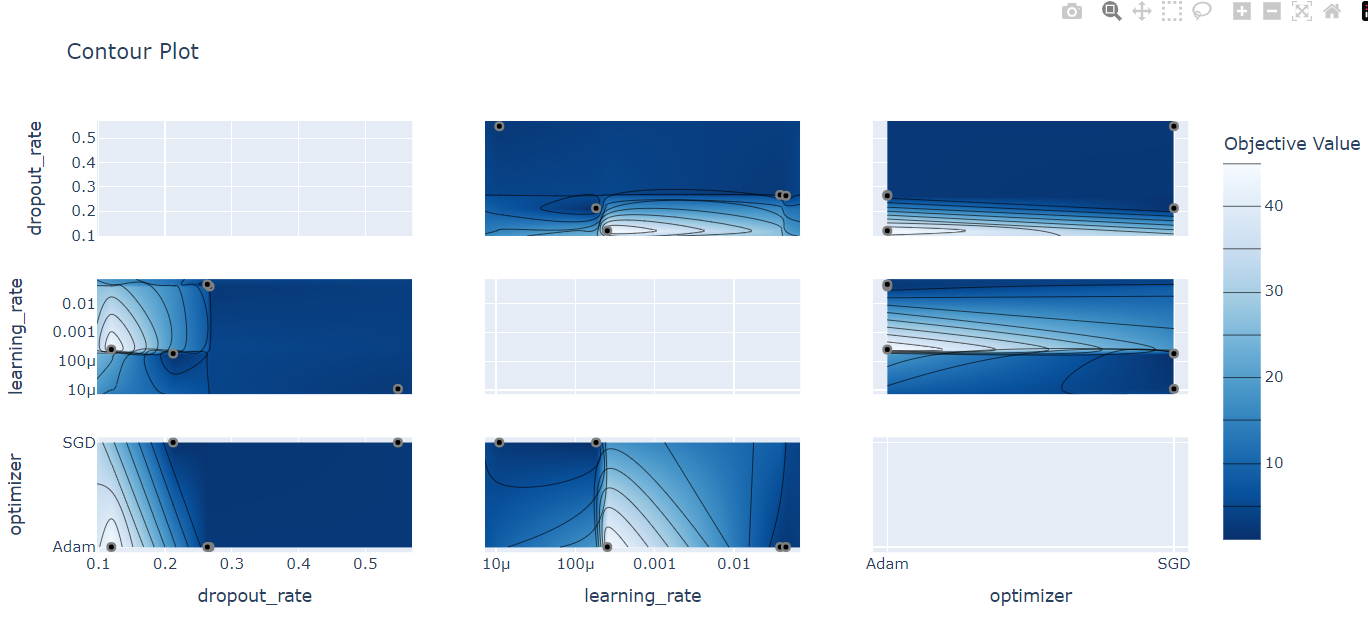

# Compare the results
After utilising Optuna to identify the hyperparameter that fits best and the optimizer that works best for the CIFAR10 Dataset the following infferences can be made:

*   For this dataset and current training scenario, Optuna has declared SGD as the better optimiser
*  The best learning value has been deemed to be 0.00018 when using SGD optimiszer

*  The model has converged towards the SGD optimzer with a lower objective value as is visible from the contour plots. Thus SGD has done a better job at converging to a minima and minimising dropout rates than Adam, contradictory to popular examples

SGD performs better on using Optuna as the hyperparamter values are designed to give it a stable dropout rate that is capable enough to reduce the validaiton loss significantly

